In [1]:
import numpy as np
import mne
from visualization_brain import *
import importlib
import kuramoto
from kuramoto import KuramotoNetwork
from scipy import stats
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import normalize

In [2]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x) ** 2 + (ny-1)*np.std(y) ** 2) / dof)

In [3]:
def cohen_d_pared(x):
    return np.mean(x)/np.std(x)

## 1. Kuramoto model 

The oscillatory mechanism (which does not depend on the spike rate) can be run first. This is done using the KuramotoNetwork class.

In [4]:
def update_sc(sc, state, collapse_subcort=True):
    """
    Updates the structual connectivity matrix such that a certain cortical network is synchronized
    """
    sc = normalize(sc, norm='l1')
    if state == 'maintenance':
        idx = np.array([14,  15,  21,  22,  23,  24,  26,  29,  43,  44,  52,  53,  54, 55,  57,  59,  60,  61,  62,  63,  64,  65,  66,  
                        77,  78, 79, 81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  95,  96, 97,  98,  99, 114, 115, 122, 126, 127, 
                        137, 141, 149, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 173, 174, 175, 176, 179, 181, 182, 183, 184, 185, 
                        186, 187, 188, 189, 190, 192, 196, 197, 198])
    elif state == 'encoding':
        idx = np.array([14,  23,  26,  40,  41,  42,  44,  50,  51,  53,  56,  58,  59, 63,  64,  65,  78, 100, 101, 102, 103, 104, 
                              105, 106, 107, 108, 109, 110, 111, 112, 113, 127, 128, 129, 130, 139, 140, 141, 147, 148, 149, 152, 153, 154, 
                              157, 158, 159, 160, 161, 174, 177, 184, 188, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 
                              212, 213])

    if collapse_subcort == True:
        idx = idx - 12

    if collapse_subcort == False:
        sc[idx, 2] = sc[idx, 2]*50
        sc[idx, 3] = sc[idx, 3]*50
        sc[idx, 4] = sc[idx, 4]*50
        sc[idx, 5] = sc[idx, 5]*50
    
        sc[idx, 9] = sc[idx, 9]*50
        sc[idx, 10] = sc[idx, 10]*50
        sc[idx, 11] = sc[idx, 11]*50
        sc[idx, 12] = sc[idx, 12]*50

    if collapse_subcort == True: 
        sc[idx, 0] = sc[idx, 0]*50
        sc[idx, 1] = sc[idx, 1]*50    

    return sc

In [5]:
def collapse_subcort(sc, dist):
    """
    If the basal-ganglia and thalamus nodes should be collapsed into one, and the other subcortical nodes removed, run this function.
    """
    sc = normalize(sc, norm='l1')

    sc_mean1_lh = np.sum(sc[2:6],axis=0)
    sc_mean2_lh = np.sum(sc[:,2:6],axis=1)
    sc_mean1_rh = np.sum(sc[9:13],axis=0)
    sc_mean2_rh = np.sum(sc[:,9:13],axis=1)
    
    dist_mean1_lh = np.mean(dist[2:6],axis=0)
    dist_mean2_lh = np.mean(dist[:,2:6],axis=1)
    dist_mean1_rh = np.mean(dist[9:13],axis=0)
    dist_mean2_rh = np.mean(dist[:,9:13],axis=1)
    
    sc = sc[12:,12:]
    dist = dist[12:,12:]
    
    sc[0] = sc_mean1_lh[12:]
    sc[:,0] = sc_mean2_lh[12:]

    sc[1] = sc_mean1_rh[12:]
    sc[:,1] = sc_mean2_rh[12:]
    
    sc[0,0] = 0
    sc[1,1] = 0
    
    dist[0] = dist_mean1_lh[12:]
    dist[:,0] = dist_mean2_lh[12:]
    
    dist[1] = dist_mean1_rh[12:]
    dist[:,1] = dist_mean2_rh[12:]
    
    dist[0,0] = 0
    dist[1,1] = 0

    return sc, dist 

In [6]:
on = KuramotoNetwork(itt=100000, network = np.load('/Users/julia.ericson/States/Code/DataSimulation/ConnectivityMatrices/sc_matrix{}.npy'.format(10)), 
                     distances=np.load('/Users/julia.ericson/States/Code/DataSimulation/DistanceMatrices/distance_matrix{}.npy'.format(10)), omega=0.04*np.ones(214))

### 1.1 Run the Kuramoto model

The simulation runs 100000 itterations for 10 subjects that each have their own structual network. It runs both 'encoding' and 'maintenance' states. 

The structual network can either be run with 7 subcortical nodes in each hemisphere (set collapse = False), or 1 subcortical node (set collapse = True). The results should be fairly similar, but I have perferred to run with only 1 subcortical node as I believe that the model simulates a cortical phenomenon which does not capture the interaction between subcortical nodes.

In [7]:
collapse = True
frequency = 0.006  # 0.006 = 6 Hz

In [ ]:
states = ['maintenance', 'encoding']
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

itt = 100000
if collapse == False:
    omega=0.04*np.ones(214)
else:
    omega=0.04*np.ones(202) 

for s in subjects:
    print('subject:', s)
    for state in states:
        if state == 'maintenance':
            if collapse == True:
                omega[[0,1]] = frequency 
            if collapse == False:
                omega[[2,9,3,10,4,11,5,12]] = frequency
        if state == 'encoding':
            if collapse == True:
                omega[[0,1]] = frequency
            if collapse == False:
                omega[[2,9,3,10,4,11,5,12]] = frequency
        dist = np.load('DataSimulation/DistanceMatrices/distance_matrix{}.npy'.format(s)).astype(int)
        sc = np.load('DataSimulation/ConnectivityMatrices/sc_matrix{}.npy'.format(s))
        sc, dist = collapse_subcort(sc, dist)
        sc = update_sc(sc, state, collapse_subcort=collapse)

        on = KuramotoNetwork(itt, sc, dist, sigma=0.05, omega=omega)
        on.run_simulation()

        np.save('DataSimulation/OscillationTimeSeries/{}_network_striatum{}_{}Hz.npy'.format(state, s, frequency*1000), on.theta)

### 1.2 Visualize

In [11]:
idx_main = np.array([14,  15,  21,  22,  23,  24,  26,  29,  43,  44,  52,  53,  54, 55,  57,  59,  60,  61,  62,  63,  64,  65,  66,  
                        77,  78, 79, 81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  95,  96, 97,  98,  99]) - 14
idx_enc = np.array([14,  23,  26,  40,  41,  42,  44,  50,  51,  53,  56,  58,  59, 63,  64,  65,  78, 100, 101, 102, 103, 104, 
                              105, 106, 107, 108, 109, 110, 111, 112, 113]) - 14

1
2
3
4
5
6
7
8
9
10
Reading forward solution from /Users/julia.ericson/States/Code/../../MEG/Data/0901/220207/M10901_fwd_fixed.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (13539 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/lh.parc2018yeo7_200.annot
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/rh.parc2018yeo7_200.annot


/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:34: RuntimeWarning: This filename (../../MEG/Data/0901/220207/M10901_fwd_fixed.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -fwd.h5 or _fwd.h5
  fwd_fixed = mne.read_forward_solution(fwd_fixed_path)


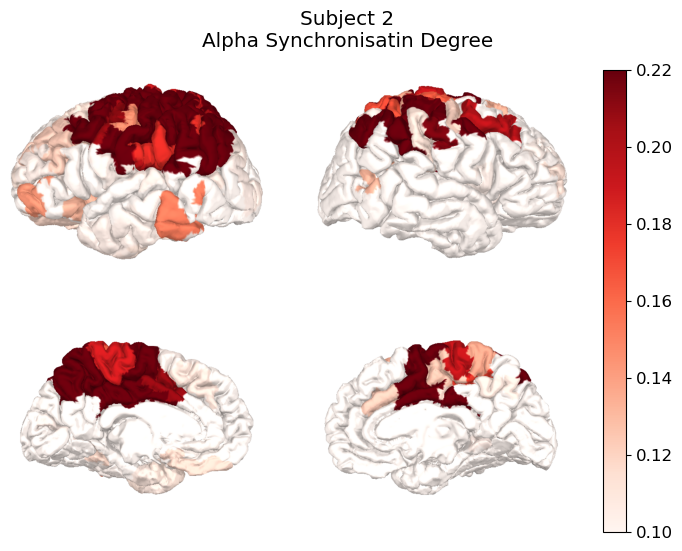

In [12]:
state = 'maintenance'
frequency = 0.006
synch_all = np.zeros((202,202))
if state == 'maintenance':
    idx = idx_main
else:
    idx = ind_enc

sych_increase = np.zeros(10)
sych_increase_percent = np.zeros(10)

for i in range(1,11):
    print(i)
    phase = np.load('DataSimulation/OscillationTimeSeries/{}_network_striatum{}_{}Hz.npy'.format(state, s, frequency*1000))
    synch = on.calculate_synchrony(phase, imag=False)
    synch_all += synch

    sych_increase[i-1] = np.mean(synch[2:102][idx]) -  np.mean(synch[2:102][~idx])
    sych_increase_percent[i-1] = np.mean(synch[2:102][idx]) /  np.mean(synch[2:102][~idx])

synch_all = synch_all/10
data = np.mean(synch_all[2:,2:],axis=1) 
max_val = np.max(data)
vis_data_on_brain(s='MRI_example_subject', data=data, title='Synchronisation', cmin=0, cmax=max_val,
                  fwd_fixed_path='SourceData/MRI_example_subject/fwd_fixed.fif'.format('0901', 220207, 1, '0901'), 
                  mri_dir='SourceData', cmap='Reds')  

res = stats.ttest_1samp(sych_increase, 0, alternative='greater')
print(res)
print(np.mean(sych_increase_procent))
print(np.std(sych_increase_procent))
print(res.confidence_interval(confidence_level=0.95))
print(cohen_d_pared(sych_increase))

## 2. Spiking Model

Runs the spike rate simulation using data from the Kuramoto model simulation.

In [26]:
n_sources = 214  # number of network nodes before collapsing
start = 2000  # starting time point for the spike rate simulation (with respect to the silmulated time series from the Kuramoto model)
time_points = 100000 - 2000  # number of illerations
k = 0.8 
decay = 0.25
w_dist = 2
dt = 0.1
collapse = True

In [47]:
states = ['maintenance', 'encoding']
frequency = 0.006
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
areas = [111, 60]
if collapse == True:
    areas = [111 - 12, 60 - 12]
    areas = [60 - 12]
    n_sources = 202

for s in subjects:
    print('subject:', s)
    dist = np.load('DataSimulation/DistanceMatrices/distance_matrix{}.npy'.format(s)).astype(int)
    sc = np.load('DataSimulation/ConnectivityMatrices/sc_matrix{}.npy'.format(s))
    sc, dist = collapse_subcort(sc, dist)
    
    for state in states:
        for n in areas:
            I_external = np.zeros((start+time_points, n_sources))
            u = np.zeros((start+time_points, n_sources))
            I_external[:,n] = 1
            oscillations = np.load('DataSimulation/OscillationTimeSeries/{}_network_striatum{}_{}Hz.npy'.format(state, s, frequency*1000))
            oscillations = np.sin(oscillations)*(-0.5) + 0.5
                
            for t in range(start,start+time_points):
                for i in range(n_sources):
                    delays = u[t - w_dist*dist[i], np.arange(n_sources)]
                    u[t,i] = (u[t-1,i] + dt*(I_external[t,i] + k*np.dot(sc[i], delays) - decay*u[t-1,i]))*oscillations[t,i]
 
            np.save('DataSimulation/SpikeRateTimeSeries/{}_network_{}_striatum{}_{}Hz.npy'.format(state, n, s, frequency*1000),u)

subject: 1
subject: 2
subject: 3
subject: 4
subject: 5
subject: 6
subject: 7
subject: 8
subject: 9
subject: 10


## 3. Entropy calculations

Calculate the entropy transfer from one node to the rest of the brain using the spike rate simulated data. 

In [29]:
def dTE_calc(probs):
    """
    Calculates transfer entropy.
    """
    size = probs.shape[0]
    dTE = 0
    pj = np.sum(np.sum(probs, axis=2), axis=0)
    pj_jd = np.sum(probs, axis=0)
    pi_j = np.sum(probs, axis=2)
    for i in range(size):
        for j in range(size):
            for k in range(size):
                nom = probs[i, j, k] * pj[j]
                denom = pj_jd[j, k] * pi_j[i, j]
                if (nom != 0) & (denom != 0):
                    dTE += probs[i, j, k] * np.log(nom/denom)
    return dTE

def calculate_information_transfer(xi, x_dat, d_dat):
    """
    1) Makes the propability distribution plots
    2) Calls on dTE_calc to get the transfer entropy for the current probablity distributions. 
    """
    dTE = []
    for xj in range(x_dat.shape[1]):
        if xi != xj:
            hist_probs = np.concatenate((x_dat[:,[xi, xj]], np.expand_dims(d_dat[:,xj], axis=1)),axis=1)
            hist_random, edges = np.histogramdd(hist_probs, bins=20, density=True, range=[(0,20), (0,20), (0,20)])
            dTE.append(dTE_calc(hist_random))
        else:
            dTE.append(0)
    return dTE

### 3.1 Run simulation

In [48]:
states = ['maintenance', 'encoding']
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
areas = [111, 60]
frequency = 0.006
if collapse == True:
    areas = [111 - 12, 60 - 12] 
    areas = [60 - 12] 
dN = 400  # The max delta T. This means that transfer entropy is calculated for delta T = 1 to delta T = 400. 

for s in subjects:
    print('subject:', s)
    for state in states:
        print('state:', state)
        for n in areas:
            print('area:', n)
            u = np.load('DataSimulation/SpikeRateTimeSeries/{}_network_{}_striatum{}_{}Hz.npy'.format(state, n, s, frequency*1000)
            u = np.divide(u, np.std(u,axis=0), out=np.zeros_like(u), where=np.std(u,axis=0)!=0)
                
            dTE_int = np.zeros(u.shape[1])
            T = u.shape[0]
                
            for d in range(1,dN+1):
                x_dat = u[:T - dN]
                d_dat = u[d:T - dN + d]
                dTE = calculate_information_transfer(n, x_dat, d_dat)
                dTE_int += dTE
            dTE_int /= dN
            # REMOVE OPPOSITE FREQ!!
            np.save('DataSimulation/EntropyTransfer/{}/{}_{}_{}Hz.npy'.format(state, n, s, frequency*1000),dTE_int)

subject: 1
state: maintenance
area: 48
subject: 2
state: maintenance
area: 48
subject: 3
state: maintenance
area: 48
subject: 4
state: maintenance
area: 48
subject: 5
state: maintenance
area: 48
subject: 6
state: maintenance
area: 48
subject: 7
state: maintenance
area: 48
subject: 8
state: maintenance
area: 48
subject: 9
state: maintenance
area: 48
subject: 10
state: maintenance
area: 48


### 3.2 Visualize the results. 

As for the synchronization visualization, the vis_data_on_brain function won't work at the moment. 

Reading forward solution from /Users/julia.ericson/States/Code/../../MEG/Data/0901/220207/M10901_fwd_fixed.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (13539 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/lh.parc2018yeo7_200.annot
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/rh.parc2018yeo7_200.annot


/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:34: RuntimeWarning: This filename (../../MEG/Data/0901/220207/M10901_fwd_fixed.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -fwd.h5 or _fwd.h5
  fwd_fixed = mne.read_forward_solution(fwd_fixed_path)


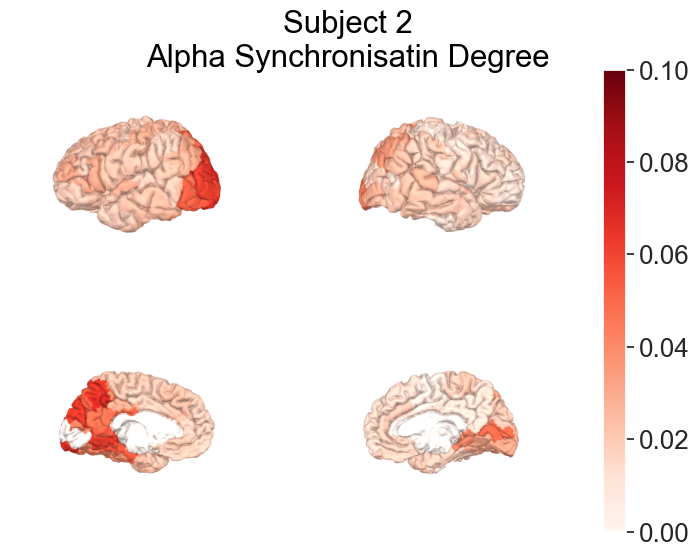

In [31]:
state = 'maintenance'
n = 111 - 12
w_dist = 2

dTE_int_all = np.zeros(202)
for s in range(1,11):
    dTE_int_all += np.load('DataSimulation/EntropyTransfer/{}/{}_{}_{}Hz.npy'.format(state, n, s, frequency*1000))

dTE_int_all = dTE_int_all/10
data = dTE_int_all[2:]
max_val = np.max(data)
vis_data_on_brain(s='MRI_example_subject', data=data, title='Transfer entropy', cmin=0, cmax=max_val,
                  fwd_fixed_path='SourceData/MRI_example_subject/fwd_fixed.fif'.format('0901', 220207, 1, '0901'), 
                  mri_dir='SourceData', cmap='Reds')  

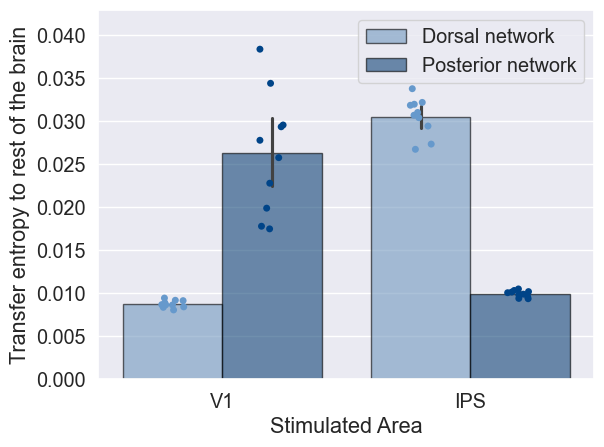

In [6]:
frequency = 0.006
for s in range(1,11):
    
    dTE_int1 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_{}Hz.npy'.format('maintenance', 111-12, s, frequency*1000))
    dTE_int2 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_{}Hz.npy'.format('encoding', 111-12, s, frequency*1000))
    
    dTE_int3 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_{}Hz.npy'.format('maintenance', 60-12, s))
    dTE_int4 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_{}Hz.npy'.format('encoding', 60-12, s, frequency*1000))

    df1 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int1), 'Synchronization': ['Dorsal network'], 'Stimulated Area': ['V1']})
    df2 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int2), 'Synchronization': ['Posterior network'], 'Stimulated Area': ['V1']})
    df3 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int3), 'Synchronization': ['Dorsal network'], 'Stimulated Area': ['IPS']})
    df4 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int4), 'Synchronization': ['Posterior network'], 'Stimulated Area': ['IPS']})

    if s == 1:
        df = pd.concat([df1, df2, df3, df4])
    else:
        df = pd.concat([df, df1, df2, df3, df4])

sns.set(font_scale=1.3)
ax = sns.barplot(x = 'Stimulated Area',
            y = 'Transfer entropy to rest of the brain',
            hue = 'Synchronization',
            data = df,
            palette = ['#6699CC', '#004488'],
            alpha = 0.6,
            edgecolor="black")

sns.stripplot(
    x='Stimulated Area', 
    y='Transfer entropy to rest of the brain', 
    hue='Synchronization', 
    data=df, dodge=True, palette = ['#6699CC', '#004488'], ax=ax, edgecolor="black"
)

plt.ylim(0,0.043)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
plt.show()

In [8]:
df_IPS = df[df['Stimulated Area'] == 'IPS']
df_V1 = df[df['Stimulated Area'] == 'V1']
t1 = df_IPS[df_IPS['Synchronization'] == 'Dorsal network']['Transfer entropy to rest of the brain'].values
t2 = df_IPS[df_IPS['Synchronization'] == 'Posterior network']['Transfer entropy to rest of the brain'].values

t3 = df_V1[df_V1['Synchronization'] == 'Posterior network']['Transfer entropy to rest of the brain'].values
t4 = df_V1[df_V1['Synchronization'] == 'Dorsal network']['Transfer entropy to rest of the brain'].values

print('V1 stimulation')
res = stats.ttest_1samp(t1-t2, 0, alternative='greater')
print(res)
print(res.confidence_interval(confidence_level=0.95))
print('Mean difference:', np.mean(t1-t2))
print('Effect size:', cohen_d_pared(t1-t2))
print('Percentage increase:', np.mean(t1) / np.mean(t2))
print('Percentage increase standard dev:',np.std(t1/t2))

print('IPS stimulation')
res = stats.ttest_1samp(t3-t4, 0, alternative='greater')
print(res)
print(res.confidence_interval(confidence_level=0.95))
print('Mean difference:', np.mean(t3-t4))
print('Effect size:', cohen_d_pared(t3-t4))
print('Percentage increase:',np.mean(t3) / np.mean(t4))
print('Percentage increase standard dev:',np.std(t3/t4))

TtestResult(statistic=26.882338511161276, pvalue=3.3010011507904184e-10, df=9)
ConfidenceInterval(low=0.019223517885535443, high=inf)
0.020630303062850807
8.960779503720426
TtestResult(statistic=7.830055893104218, pvalue=1.313312856416763e-05, df=9)
ConfidenceInterval(low=0.013470528313235888, high=inf)
0.01758812619994554
2.6100186310347393


In [23]:
idx_maintenance = np.array([ 14,  15,  21,  22,  23,  24,  26,  29,  43,  44,  52,  53,  54, 55,  57,  59,  60,  61,  62,  63,  64,  65,  66,  
                             77,  78, 79, 81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  95,  96, 97,  98,  99, 114, 115, 122, 126, 127, 
                             137, 141, 149, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 173, 174, 175, 176, 179, 181, 182, 183, 184, 185, 
                             186, 187, 188, 189, 190, 192, 196, 197, 198]) - 12

idx_encoding = np.array([14,  23,  26,  40,  41,  42,  44,  50,  51,  53,  56,  58,  59, 63,  64,  65,  78, 100, 101, 102, 103, 104, 105, 106,
                           107, 108, 109, 110, 111, 112, 113, 127, 128, 129, 130, 139, 140, 141, 147, 148, 149, 152, 153, 154, 157, 158, 159, 
                           160, 161, 174, 177, 184, 188, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213]) - 12

In [26]:
diff_maintain = np.zeros(10)
diff_encode = np.zeros(10)
for s in range(1,11):       
    dTE = np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format('maintenance', 60-12, s))
    mask = np.ones(dTE.shape[0], dtype=bool)
    mask[idx_maintenance] = False
    diff_maintain[s-1] = np.mean(dTE[idx_maintenance]) - np.mean(dTE[mask])

    dTE = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_opposite_freq.npy'.format('encoding', 111-12, s))
    mask = np.ones(dTE.shape[0], dtype=bool)
    mask[idx_encoding] = False
    diff_encode[s-1] = np.mean(dTE[idx_encoding]) - np.mean(dTE[mask])

print('V1 stimulation in posterior network')
res = stats.ttest_1samp(diff_encode, 0)
print(res)
print(res.confidence_interval(confidence_level=0.95))
print('Mean difference:', np.mean(diff_encode))
print('Effect size:', cohen_d_pared(diff_encode))

print('IPS stimulation in dorsal network')
res = stats.ttest_1samp(diff_maintain, 0)
print(res)
print(res.confidence_interval(confidence_level=0.95))
print('Mean difference:', np.mean(diff_maintain))
print('Effect size:', cohen_d_pared(diff_maintain))

TtestResult(statistic=8.600440655734735, pvalue=1.2359955343332456e-05, df=9)
ConfidenceInterval(low=0.013442897261383532, high=0.023038538214157186)
0.01824071773777036
2.8668135519115787
TtestResult(statistic=15.948385129067924, pvalue=6.616470074205704e-08, df=9)
ConfidenceInterval(low=0.01612205747079347, high=0.0214515942687203)
0.018786825869756885
5.316128376355974


## 4. Influence of frequency

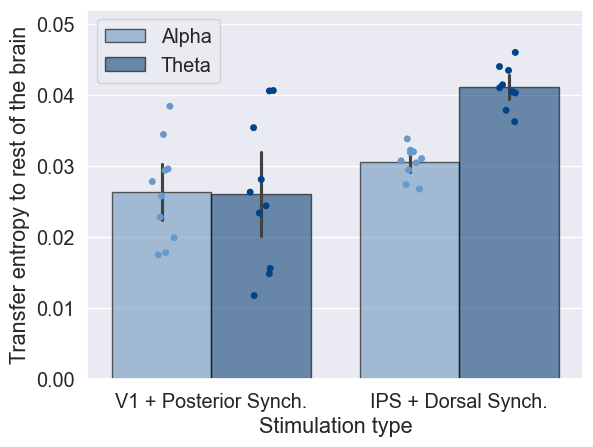

In [10]:
for s in range(1,11):

    dTE_int1 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_6Hz.npy'.format('maintenance', 60-12, s))
    dTE_int2 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_10Hz.npy'.format('maintenance', 60-12, s))
        
    dTE_int3 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_6Hz.npy'.format('encoding', 111-12, s))
    dTE_int4 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_10Hz.npy'.format('encoding', 111-12, s))
    
    df1 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int1), 'Synchronization': ['Theta'], 'Stimulation type': ['IPS + Dorsal Synch.']})
    df2 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int2), 'Synchronization': ['Alpha'], 'Stimulation type': ['IPS + Dorsal Synch.']})
    df3 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int3), 'Synchronization': ['Theta'], 'Stimulation type': ['V1 + Posterior Synch.']})
    df4 = pd.DataFrame({'Transfer entropy to rest of the brain': np.mean(dTE_int4), 'Synchronization': ['Alpha'], 'Stimulation type': ['V1 + Posterior Synch.']})
    
    if s == 1:
        df = pd.concat([df4, df3, df2, df1])
    else:
        df = pd.concat([df,df4, df3, df2, df1])

sns.set(font_scale=1.3)
ax = sns.barplot(x = 'Stimulation type',
            y = 'Transfer entropy to rest of the brain',
            hue = 'Synchronization',
            data = df,
            palette = ['#6699CC', '#004488'],
            alpha = 0.6,
            edgecolor="black")

sns.stripplot(
    x='Stimulation type', 
    y='Transfer entropy to rest of the brain', 
    hue='Synchronization', 
    data=df, dodge=True, palette = ['#6699CC', '#004488'], ax=ax, edgecolor="black"
)

plt.ylim(0,0.052)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
plt.show()

In [11]:
df_IPS = df[df['Stimulation type'] == 'IPS + Dorsal Synch.']
df_V1 = df[df['Stimulation type'] == 'V1 + Posterior Synch.']
t1 = df_IPS[df_IPS['Synchronization'] == 'Alpha']['Transfer entropy to rest of the brain'].values
t2 = df_IPS[df_IPS['Synchronization'] == 'Theta']['Transfer entropy to rest of the brain'].values

t3 = df_V1[df_V1['Synchronization'] == 'Alpha']['Transfer entropy to rest of the brain'].values
t4 = df_V1[df_V1['Synchronization'] == 'Theta']['Transfer entropy to rest of the brain'].values

print('IPS stimulation under dorsal synchronization')
res = stats.ttest_1samp(t2-t1, 0)
print(res)
print(res.confidence_interval(confidence_level=0.95))
print('mean difference:', np.mean(t2-t1))
print('effect size:', cohen_d_pared(t2-t1))

print('V1 stimulation under posterior synchronization')
res = stats.ttest_1samp(t3-t4, 0)
print(res)
print(res.confidence_interval(confidence_level=0.95))
print('mean difference:', np.mean(t3-t4))
print('effect size:', cohen_d_pared(t3-t4))

TtestResult(statistic=11.639145813762214, pvalue=9.982771355405737e-07, df=9)
ConfidenceInterval(low=0.008484574030010517, high=0.012578306171342302)
0.01053144010067641
3.8797152712540712
TtestResult(statistic=0.19035348077905423, pvalue=0.8532565375665697, df=9)
ConfidenceInterval(low=-0.002715589329055341, high=0.00321459595372031)
0.00024950331233248457
0.06345116025968475


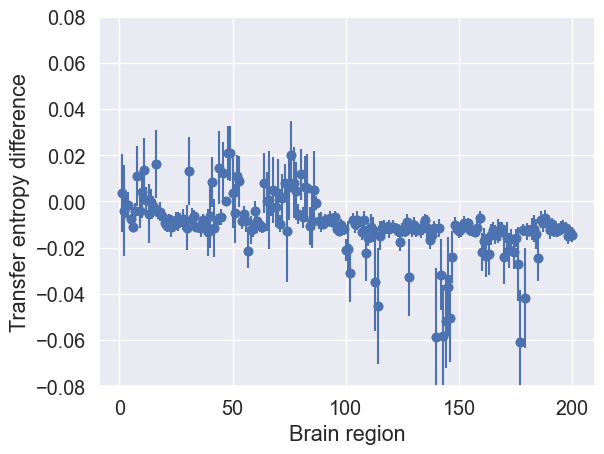

In [35]:
plt.rcParams['text.usetex'] = False

all = np.zeros((10,202))
for s in range(1,11):    
    dTE_int1 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}_opposite_freq6.npy'.format('maintenance', 60-12, s))
    dTE_int2 = np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format('maintenance', 60-12, s))
    
    all[s - 1] = dTE_int2 - dTE_int1
plt.scatter(range(1, dTE_int1.shape[0] - 1), np.mean(all,axis=0)[2:], label=s)
plt.errorbar(range(1, dTE_int1.shape[0] - 1), np.mean(all,axis=0)[2:], yerr=np.std(all,axis=0)[2:], fmt="o")
plt.ylim(-0.08,0.08)
plt.xlabel('Brain region')
plt.ylabel('Transfer entropy difference')
plt.show()

In [14]:
all[:,2:]
p_values = np.zeros(200)
index_sig = []
p_sig = 0.05/200
for i in range(200):
    if i == 48:
        p_values[i] = 1
    else:
        res = stats.ttest_1samp(all[:,i], 0)
        p_values[i] = res.pvalue
        
for i in range(200):
    print(np.min(p_values), p_sig, np.argmin(p_values))
    if (np.min(p_values) < p_sig):
        index_sig.append(np.argmin(p_values))
        p_values[np.argmin(p_values)] = 1
        if  (p_sig <= 0.05) & (i < 199):
            p_sig = ((i+2)/200)*0.05
index_sig = np.sort(index_sig)

1.2606611973988004e-07 0
2.2084690538834948e-07 1
0.5443668654036423 2
0.5591077018816144 3
0.518405070229236 4
0.48528484646952574 5
9.878742963939527e-07 6
1.1927773900019058e-07 7
0.005704089061632852 8
0.033129696245285 9
0.12643335307016382 10
0.30491908677620966 11
0.015283316567713229 12
0.7656310460503756 13
0.24345796666320382 14
0.9060926306778532 15
0.21334092116882983 16
0.009251514946724694 17
0.0016141019145574386 18
0.0086786455902266 19
0.0002873348427845315 20
3.826434589592617e-06 21
3.6872247511777095e-07 22
2.99030515117098e-06 23
4.1120197009372994e-05 24
4.945643570695949e-06 25
6.494807950238192e-05 26
9.525258189758394e-05 27
3.101415191935564e-05 28
0.0006359869214286613 29
5.170958987255824e-07 30
0.0069464847515145044 31
0.025013707767038797 32
0.001123001676176693 33
4.39698924562949e-05 34
6.354731367704233e-08 35
6.073454640923846e-07 36
2.293836089752334e-05 37
3.54353256537781e-06 38
1.3556197784716324e-05 39
0.0036632892871202648 40
0.18292003658174794 

[98,
 121,
 123,
 157,
 133,
 195,
 158,
 35,
 182,
 193,
 119,
 124,
 91,
 127,
 7,
 0,
 97,
 179,
 194,
 156,
 155,
 1,
 100,
 101,
 22,
 64,
 150,
 125,
 93,
 199,
 30,
 95,
 36,
 198,
 108,
 111,
 176,
 122,
 196,
 159,
 126,
 138,
 6,
 151,
 139,
 99,
 117,
 154,
 192,
 170,
 166,
 174,
 181,
 152,
 140,
 132,
 197,
 63,
 167,
 92,
 23,
 107,
 38,
 21,
 135,
 130,
 191,
 136,
 134,
 165,
 25,
 153,
 162,
 169,
 60,
 120,
 149,
 142,
 44,
 118,
 175,
 131,
 58,
 39,
 173,
 96,
 147,
 178,
 161,
 72,
 105,
 37,
 144,
 188,
 145,
 28,
 104,
 168,
 163,
 103,
 128,
 24,
 186,
 164,
 34,
 89,
 183,
 190,
 116,
 26,
 55,
 94,
 113,
 172,
 27,
 160,
 189,
 187,
 148,
 185,
 137,
 90,
 143,
 109,
 171,
 184,
 59,
 46,
 112,
 129,
 141,
 180,
 106,
 20,
 110,
 115,
 49,
 57,
 50,
 146,
 29,
 102,
 177,
 62,
 114,
 33,
 82,
 56,
 18,
 77,
 85,
 80,
 40,
 53,
 8,
 31,
 19,
 17,
 81,
 74,
 61,
 12,
 47,
 43,
 45,
 32,
 9]

Reading forward solution from /Users/julia.ericson/States/Code/../../MEG/Data/0901/220207/M10901_fwd_fixed.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read


/Users/julia.ericson/States/Code/../../MEG/Code/visualisations_brain.py:34: RuntimeWarning: This filename (../../MEG/Data/0901/220207/M10901_fwd_fixed.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -fwd.h5 or _fwd.h5
  fwd_fixed = mne.read_forward_solution(fwd_fixed_path)


    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (13539 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/lh.parc2018yeo7_200.annot
Reading labels from parcellation...
   read 101 labels from /Users/julia.ericson/MEG/Data/MRIs/0901MRI/label/rh.parc2018yeo7_200.annot


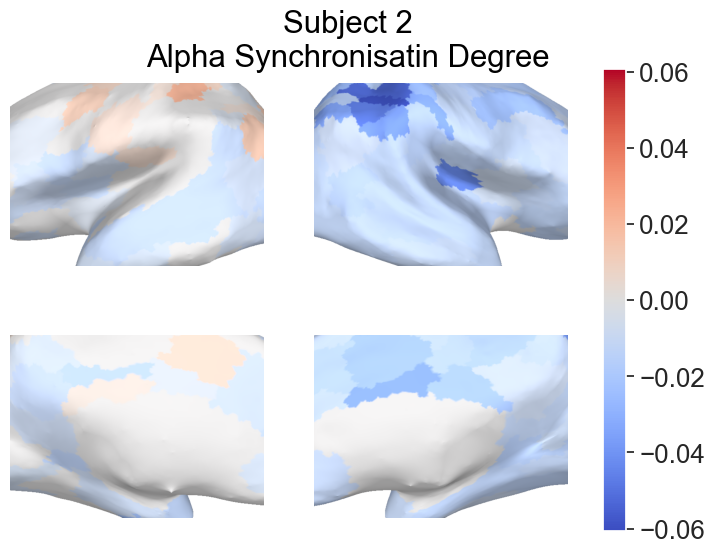

In [54]:
state1 = 'maintenance'
state2 = 'maintenance'
n = 60 - 12

dTE_int_all = np.zeros(202)
for s in range(1,11):
    dTE_int = np.load('DataSimulation/EntropyTransfer/{}/{}_{}.npy'.format(state2, n, s))
    dTE_int -= np.load('DataSimulation/EntropyTransfer/{}/{}_{}_opposite_freq6.npy'.format(state1, n, s))
    dTE_int_all += dTE_int

dTE_int_all = dTE_int_all/10

data = dTE_int_all[2:]
max_val = np.max(np.abs(data))

mask = np.ones(data.shape[0], dtype=bool)
mask[index_sig] = False

data[mask] = 0

vis_data_on_brain(s='MRI_example_subject', data=data, title='Transfer entropy', cmin=0, cmax=max_val,
                  fwd_fixed_path='SourceData/MRI_example_subject/fwd_fixed.fif'.format('0901', 220207, 1, '0901'), 
                  mri_dir='SourceData', cmap='Reds')  